Off-the-shelf method using Surprise library from scikit for collaborative filtering.

The Surprise library offers matrix factorization-based prediction algorithms such as SVD, SVD++, NMF.

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from surprise import Dataset, evaluate, Reader, accuracy
from surprise.prediction_algorithms import predictions, matrix_factorization
from surprise.model_selection import cross_validate, GridSearchCV

In [2]:
with open('data/new_files/get_movies.pkl', 'rb') as f:
    t = pickle.load(f)
    
movie_dic = t[0]
movie_genre_dic = t[1]

with open('data/new_files/get_ratings.pkl', 'rb') as f:
    lst = pickle.load(f)

In [3]:
# load train and test data
r = Reader(sep='\t')
train_data = Dataset.load_from_file('data/new_files/train.txt', reader=r)
train_Y = train_data.build_full_trainset()

test_data = Dataset.load_from_file('data/new_files/test.txt', reader=r)
test_Y = test_data.build_full_trainset()
test_data = test_Y.build_testset()

In [4]:
k = 20

# SVD
svd = matrix_factorization.SVD(n_factors=k, verbose=True)

# SVD++ algorithm aka extension of SVD taking into account implicit ratings
svdpp = matrix_factorization.SVDpp(n_factors=k, verbose=True)

# Non-negative Matrix factorization
nmf = matrix_factorization.NMF(n_factors=k, biased=True, verbose=True)

# Fit and train, compute root mean square error
for model in [svd, svdpp, nmf]:
    model.fit(train_Y)
    print(model)
    accuracy.rmse(model.test(test_data)) # Then compute RMSE
    print()
    
# Results: (SVD algo had best RMSE)
# <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x0000015C1957C240>
# RMSE: 0.9291, epochs: 20

# <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x0000015C1957C9E8>
# RMSE: 0.9187, epochs: 20

# <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x0000015C1957CBE0>
# RMSE: 1.1213, epochs: 50

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
RMSE: 0.9310

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
RMSE: 0.9116

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
P

In [5]:
k = 20
eta = 0.007
reg = 0.055

model = matrix_factorization.SVD(n_factors=k, lr_all=eta, reg_all=reg, verbose=True)
model.fit(train_Y)
accuracy.rmse(model.test(test_data)) # epochs: 19, RMSE: 0.9510756520444057 on predictions

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
RMSE: 0.9202


0.9202213527588236

In [6]:
'''
This function performs matrix factorization.
Input:
    Y_train: training labels
    test_set: test set
Output: 
    newU: The 2D version of U
    newV: The 2D version of V
'''
def matrix_factor(model, train_Y):
    """ Uses matrix factorization-based algorithm SVD++
    and returns U (k x m matrix) and V (k x n matrix)
    where k in the number of factors of the model. """    
    # get user factors
    U = model.pu    
    print("U shape: " + str(U.shape)) # (m, k) = (943, 20)

    # transpose item factors
    V = np.transpose(model.qi)    
    print("V shape: " + str(V.shape)) # (k, n) = (20, 1682)
    
    return U, V
    
def SVD(U, V):
    """ Applies SVD to V and uses the ﬁrst two columns of A
    to project U,V into 2-D space. """    
    # get A matrix
    A, _, _ = np.linalg.svd(V) 
    # take first two columns of A
    A = A[:, [0, 1]] # (k, 2) = (5, 2)
    print("A shape: " + str(A.shape))

    # project U into 2-D space
    U_tilda = np.transpose(np.dot(np.transpose(A), np.transpose(U)))
    print("U shape: " + str(U_tilda.shape)) # (943, 2)

    # project V into 2-D space
    V_tilda = np.transpose(np.dot(np.transpose(A), V))
    print("V shape: " + str(V_tilda.shape)) # (1682, 2)

    return U_tilda, V_tilda

In [7]:
U, V = matrix_factor(model, train_Y)

U shape: (943, 20)
V shape: (20, 1668)


In [8]:
U_tilda, V_tilda = SVD(U, V)

A shape: (20, 2)
U shape: (943, 2)
V shape: (1668, 2)


In [9]:
with open("matrices/surprise_best_model_eta_{}_reg_{}_epoch_{}_testerr_{}.matrix".format(eta, reg, 20, 0.9200), "wb+") as f:
    np.save(f, V_tilda)

# visualizations

In [10]:
indices = np.random.randint(1668, size=10)

In [11]:
x = [V_tilda[i][0] for i in indices]
y = [V_tilda[i][1] for i in indices]

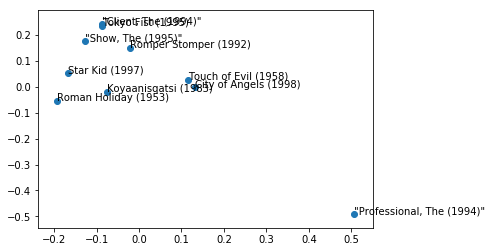

In [12]:
plt.scatter(x,y)
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.annotate(movie_dic[indices[i]], (xi, yi))

In [13]:
num_ratings_vs_movies = [0 for i in movie_dic.keys()]
for (i, j, yij) in lst:
    num_ratings_vs_movies[j] += 1
num_ratings_vs_movies = np.array(num_ratings_vs_movies)

In [14]:
indices = num_ratings_vs_movies.argsort()[-10:][::-1]

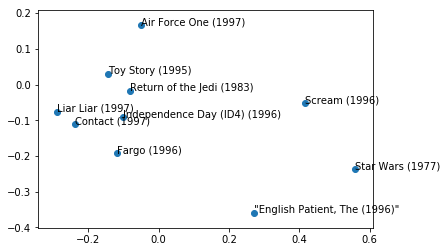

In [15]:
x = [V_tilda[i][0] for i in indices]
y = [V_tilda[i][1] for i in indices]
plt.scatter(x,y)

for i, (xi, yi) in enumerate(zip(x, y)):
    plt.annotate(movie_dic[indices[i]], (xi, yi))

In [16]:
movie_rating_dic = {id: [] for id in movie_dic.keys()} # dic of movie id and ratings

for rating in lst:
    _, movie_id, r = rating
    movie_rating_dic[movie_id].append(r)

avg_ratings = {movie: sum(movie_rating_dic[movie]) / len(movie_rating_dic[movie]) \
               for movie in movie_rating_dic}

# get ten best movies that received highest average rating
top_10 = sorted(avg_ratings.items(), key=lambda tup: tup[1], reverse=True)[:10]
indices = [t[0] for t in top_10]

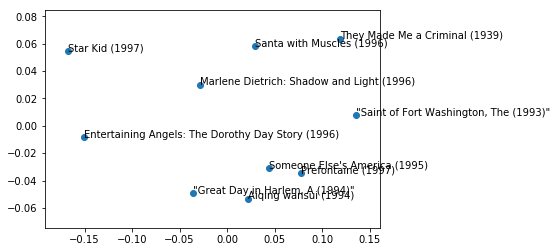

In [17]:
x = [V_tilda[i][0] for i in indices]
y = [V_tilda[i][1] for i in indices]
plt.scatter(x,y)
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.annotate(movie_dic[indices[i]], (xi, yi))

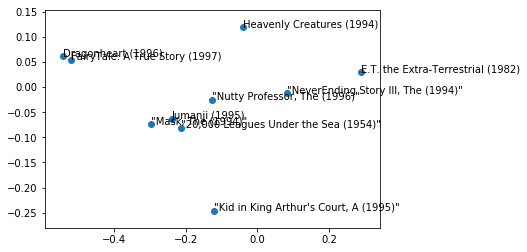

In [18]:
fant_movies = movie_genre_dic['Fantasy']
indices = fant_movies[:10]
x = [V_tilda[i][0] for i in indices]
y = [V_tilda[i][1] for i in indices]
plt.scatter(x,y)

for i, (xi, yi) in enumerate(zip(x, y)):
    plt.annotate(movie_dic[indices[i]], (xi, yi))

[31, 47, 74, 114, 118, 319, 359, 633, 643, 644]


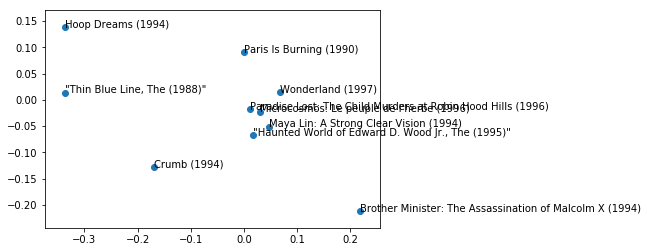

In [19]:
fant_movies = movie_genre_dic['Documentary']
indices = fant_movies[:10]
print(indices)
x = [V_tilda[i][0] for i in indices]
y = [V_tilda[i][1] for i in indices]
plt.scatter(x,y)

for i, (xi, yi) in enumerate(zip(x, y)):
    plt.annotate(movie_dic[indices[i]], (xi, yi))

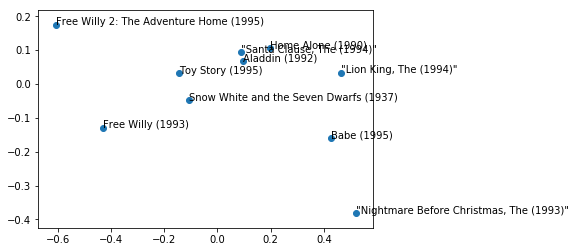

In [20]:
fant_movies = movie_genre_dic["Children's"]
indices = fant_movies[:10]
x = [V_tilda[i][0] for i in indices]
y = [V_tilda[i][1] for i in indices]
plt.scatter(x,y)

for i, (xi, yi) in enumerate(zip(x, y)):
    plt.annotate(movie_dic[indices[i]], (xi, yi))

[0, 7, 34, 62, 70, 77, 90, 93, 94, 98]


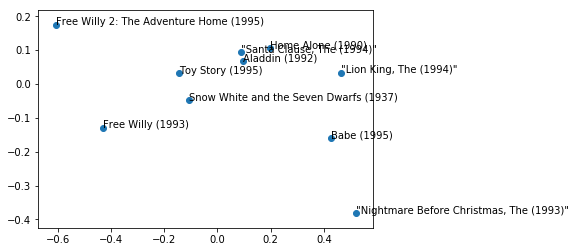

In [21]:
fant_movies = movie_genre_dic["Children's"]
indices = fant_movies[:10]
print(indices)
x = [V_tilda[i][0] for i in indices]
y = [V_tilda[i][1] for i in indices]
plt.scatter(x,y)

for i, (xi, yi) in enumerate(zip(x, y)):
    plt.annotate(movie_dic[indices[i]], (xi, yi))